In [1]:
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from pickledataset import SeqDataset
from matplotlib import pyplot as plt

In [2]:
device = torch.device('cuda')

In [3]:
filename = '2000_line_100k_len_April_3.pickle'
data = SeqDataset(filename, 2000)
len(data)

2000

In [4]:
class autoencoder(nn.Module):
    def __init__(self, embed_size=512):
        super(autoencoder, self).__init__()
        self.encoder_conv1 = nn.Conv2d(1, 8, (1, 5), stride=5)
        self.encoder_conv2 = nn.Conv2d(8, 16, (1, 10), stride=10)
        self.encoder_fc1 = nn.Linear(16*2000, embed_size)
        
        self.decoder_fc1 = nn.Linear(embed_size, 16*2000)
        self.decoder_deconv1 = nn.ConvTranspose2d(16, 8, (1, 10), stride=10)
        self.decoder_deconv2 = nn.ConvTranspose2d(8, 1, (1, 5), stride=5)
        
        
    def forward(self, input):
        input = F.relu(self.encoder_conv1(input))
        input = F.relu(self.encoder_conv2(input))
        input = input.view(-1, 16*1*2000)
        input = F.relu(self.encoder_fc1(input))
        
        recon = F.relu(self.decoder_fc1(input))
        recon = recon.reshape([1, 16, 1, 2000])
        recon = F.relu(self.decoder_deconv1(recon))
        recon = F.relu(self.decoder_deconv2(recon))
        
        return recon

In [5]:
def convert_data(l):
    result = []
    for i in l:
        result.append(torch.unsqueeze(i, 0)[None, ...].to(device, dtype = torch.float))
    return result

In [6]:
ae = autoencoder(embed_size=512).to(device)
optimizer = optim.SGD(ae.parameters(), lr=1e-4, momentum=0.8)
criterion = nn.MSELoss()
data = SeqDataset(filename, 2000)

epochs = 2
counter = 0
counts, losses = [], []
for epoch in range(epochs):
    for i in range(2000):
        running_loss = 0
        items = convert_data(data.__getitem__(i))
        
        optimizer.zero_grad()
        output = ae(items[0])
        #print(items[0])
        #print(output.shape, item.shape)
        loss = criterion(output, items[0])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        counts.append(counter)
        counter += 1
        losses.append(running_loss)
        
    data = SeqDataset(filename, 2000)

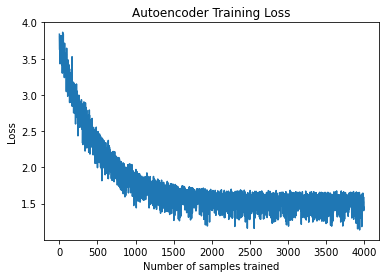

In [7]:
plt.plot(counts, losses)
plt.title('Autoencoder Training Loss')
plt.xlabel('Number of samples trained')
plt.ylabel('Loss')
plt.show()